In [1]:
# Notebook showing how one might restore a run to a given point and inspect the reward function

In [1]:
import numpy as np
import lsst.sims.featureScheduler as fs
from lsst.sims.speedObservatory import Speed_observatory
import matplotlib.pylab as plt
import healpy as hp
from lsst.sims.utils import _hpid2RaDec

/Users/yoachim/gitRepos/sims_featureScheduler/python/lsst/sims/featureScheduler/utils.py:27: UserWarning: Could not import ts.scheduler. This is required to load the FieldsDatabase. In this case
it will fallback to loading fields from the local "fieldID.lis" file.
  it will fallback to loading fields from the local "fieldID.lis" file.''')


In [2]:
# Want to load up a saved survey and inspect it at a point where things were strange
observations = fs.sqlite2observations('block_test1yrs.db')

In [3]:
# Configure the scheduler the way it was before.  Might be nice to save a copy of the staring scheduler from now on.

# Get rid of the silly north stripe
def standard_goals(nside=None):
    """
    A quick function to generate the "standard" goal maps.
    """
    # Find the number of healpixels we expect to observe per observation
    if nside is None:
        nside = fs.set_default_nside()

    result = {}
    result['u'] = fs.generate_goal_map(nside=nside, NES_fraction=0.,
                                    WFD_fraction=0.31, SCP_fraction=0.15,
                                    GP_fraction=0.15, WFD_upper_edge_fraction=0.)
    result['g'] = fs.generate_goal_map(nside=nside, NES_fraction=0.2,
                                    WFD_fraction=0.44, SCP_fraction=0.15,
                                    GP_fraction=0.15, WFD_upper_edge_fraction=0.)
    result['r'] = fs.generate_goal_map(nside=nside, NES_fraction=0.46,
                                    WFD_fraction=1.0, SCP_fraction=0.15,
                                    GP_fraction=0.15, WFD_upper_edge_fraction=0.)
    result['i'] = fs.generate_goal_map(nside=nside, NES_fraction=0.46,
                                    WFD_fraction=1.0, SCP_fraction=0.15,
                                    GP_fraction=0.15, WFD_upper_edge_fraction=0.)
    result['z'] = fs.generate_goal_map(nside=nside, NES_fraction=0.4,
                                    WFD_fraction=0.9, SCP_fraction=0.15,
                                    GP_fraction=0.15, WFD_upper_edge_fraction=0.)
    result['y'] = fs.generate_goal_map(nside=nside, NES_fraction=0.,
                                       WFD_fraction=0.9, SCP_fraction=0.15,
                                       GP_fraction=0.15,
                                       WFD_upper_edge_fraction=0.)

    return result

nside = fs.set_default_nside(nside=32)


# Let's set up some alt_az maps
alt_az_blockmaps = []
# Bump up nside to make interpolation work
hpids = np.arange(hp.nside2npix(nside*2))
az, alt = _hpid2RaDec(nside*2, hpids)

alt_low_limit = np.radians(20.)
alt_high_limit = np.radians(82.)
az_half_width = np.radians(15.)

blank_map = hpids *0.
good = np.where( ((az > 2.*np.pi-az_half_width) | (az < az_half_width)) &
                (alt > alt_low_limit) & (alt < alt_high_limit))
new_map = blank_map +0
new_map[good] = 1
alt_az_blockmaps.append(new_map)

good = np.where(((az > np.pi-az_half_width) & (az < np.pi+az_half_width)) &
                (alt > alt_low_limit) & (alt < alt_high_limit))
new_map = blank_map +0
new_map[good] = 1
alt_az_blockmaps.append(new_map)

# let's expand this one a bit
good = np.where((az > np.pi/2 - az_half_width*2) & (az < np.pi/2+az_half_width*2) & 
               (alt > alt_low_limit) & (alt < alt_high_limit))
new_map = blank_map +0
new_map[good] = 1
alt_az_blockmaps.append(new_map)

# get rid of silly northern strip.
target_map = standard_goals(nside=nside)

#filters = ['u', 'g', 'r', 'i', 'z', 'y']
filters = ['r']
surveys = []

# To really get going, could use m5 and target map of multiple filters. Then 
# it'll pick the block scheduler that is best for both filters.
for filtername in filters:
    bfs = []
    bfs.append(fs.M5_diff_basis_function(filtername=filtername, nside=nside))
    bfs.append(fs.Target_map_basis_function(filtername=filtername,
                                            target_map=target_map[filtername],
                                            out_of_bounds_val=hp.UNSEEN, nside=nside))
    bfs.append(fs.Slewtime_basis_function(filtername=filtername, nside=nside))
    # I think this will help make patches more clumpy
    bfs.append(fs.Constant_basis_function())
    # XXX--put a huge boost on staying in the filter. Until I can tier surveys as list-of-lists
    weights = np.array([3.0, 0.3, 3., 50.])
    # Might want to try ignoring DD observations here, so the DD area gets covered normally--DONE
    surveys.append(fs.Block_survey(bfs, weights, filtername=filtername,
                                   dither=True, nside=nside, ignore_obs='DD',
                                   alt_az_masks=alt_az_blockmaps))
    
# Let's set up a standard survey as well to fill in the gaps
filtername = 'y'
bfs = []
bfs.append(fs.M5_diff_basis_function(filtername=filtername, nside=nside))
bfs.append(fs.Target_map_basis_function(filtername=filtername,
                                        target_map=target_map[filtername],
                                        out_of_bounds_val=hp.UNSEEN, nside=nside))

bfs.append(fs.North_south_patch_basis_function(zenith_min_alt=50., nside=nside))
#bfs.append(fs.Zenith_mask_basis_function(maxAlt=78., penalty=-100, nside=nside))
bfs.append(fs.Slewtime_basis_function(filtername=filtername, nside=nside))
bfs.append(fs.Strict_filter_basis_function(filtername=filtername))

# Put a negative on the filter change so I try to get out of this filter when possible
weights = np.array([3.0, 0.3, 1., 3., -4.])
# Might want to try ignoring DD observations here, so the DD area gets covered normally--DONE
surveys.append(fs.Greedy_survey_fields(bfs, weights, block_size=1, filtername=filtername,
                                       dither=True, nside=nside, ignore_obs='DD'))
scheduler = fs.Core_scheduler(surveys, nside=nside)

In [4]:
# set up the observatory
observatory = Speed_observatory(nside=nside, quickTest=True)

(59695, 59710)

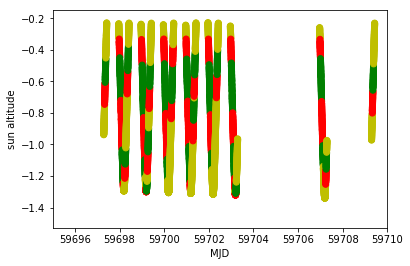

In [5]:
plt.scatter(observations['mjd'], observations['sunAlt'], c=observations['filter'])
plt.xlabel('MJD')
plt.ylabel('sun altitude')
#plt.xlim([observations['mjd'].min()+1, observations['mjd'].min()+5.4])
plt.xlim([59695, 59710])

In [6]:
np.where((observations['mjd'] > 59702) & (observations['sunAlt'] < -1.2) & (observations['filter'] == 'y'))[0]

array([ 47330,  47331,  47332, ..., 108431, 108432, 108433])

In [7]:
# play observations back into scheduler
obs_max = 47332
for obs in observations[0:obs_max]:
    scheduler.add_observation(obs)


In [8]:
# set the observatory up about right
observatory.set_mjd(obs['mjd'])
observatory.ra = obs['RA']
observatory.dec = obs['dec']
status = observatory.return_status()
scheduler.update_conditions(status)

/Users/yoachim/gitRepos/sims_seeingModel/python/lsst/sims/seeingModel/seeingModel.py:133: RuntimeWarning: invalid value encountered in power
  airmass_correction = np.power(airmass, 0.6)


In [9]:
scheduler.surveys[0]._check_feasability()

True

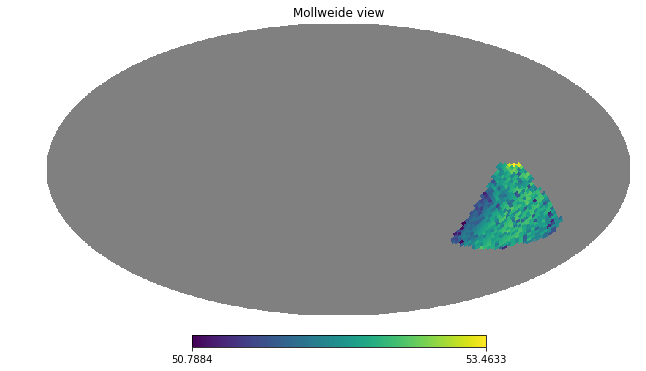

In [12]:
hp.mollview(scheduler.surveys[0].calc_reward_function())